# Workspace setup

In [1]:
import os
import urllib
import zipfile
import itertools
import gc
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')

PARENT_DIR = Path().resolve().parents[0] 
DATA_DIR = PARENT_DIR / 'data'
DATA_URL = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'

data_name = 'tripdata'
companies = ['yellow']
years = ['2017']
months = ['03', '06', '11']
cos = ''.join([c[0] for c in set(companies)])
yrs = ''.join([y[-2:] for y in set(years)])
mos = ''.join(months)
dates = ['-'.join([y,m]) for y, m in itertools.product(years, months)]

taxi_data_csv_names = ['_'.join([c, data_name, d]) + '.csv'
                       for c, d in itertools.product(companies, dates)]
taxi_data_pattern = DATA_DIR / '*_tripdata_*-*.csv'
csv_urls = [DATA_URL + f for f in taxi_data_csv_names]
csv_files = [DATA_DIR / f for f in taxi_data_csv_names]
csv_dict = dict(zip(taxi_data_csv_names, zip(csv_urls, csv_files)))
parquet_name = DATA_DIR / '_'.join([cos, yrs, mos])

lookup_name = DATA_DIR / 'taxi_zone_lookup.csv'
shapefile_name = DATA_DIR / 'taxi_zones.zip'

numerical_cols = ['passenger_count', 'trip_distance', 'fare_amount',
                  'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                  'improvement_surcharge', 'total_amount']

categorical_cols = ['VendorID', 'RatecodeID',
                    'store_and_fwd_flag', 'payment_type']

location_cols = ['PULocationID', 'DOLocationID']

datetime_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

categorical_dict = {'VendorID': {1: 'Creative Mobile',
                                 2: 'VeriFone'},
                    'RatecodeID': {1: 'Standard',
                                   2: 'JFK',
                                   3: 'Newark',
                                   4: 'Nassau/Westchester',
                                   5: 'Negotiated',
                                   6: 'Group'},
                    'store_and_fwd_flag': {0: 'not store and forward',
                                           1: 'store and forward'},
                    'payment_type': {1: 'Credit',
                                     2: 'Cash',
                                     3: 'No charge',
                                     4: 'Dispute',
                                     5: 'Unknown',
                                     6: 'Voided'}}

# Downloading data

In [2]:
def dwnld_data(csv_name):
    ''' Downloads file from the url and save it as filename '''
    # check if file already exists
    url, filename = csv_dict[csv_name]
    if not filename.exists():
        print(f'Downloading {csv_name}')
        urllib.request.urlretrieve(url, filename)
    else:
        print(f'{csv_name} exists')

def dwnl_location_lookup():
    url = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv'
    filename = lookup_name
    if not filename.exists():
        print('Downloading lookup table')
        urllib.request.urlretrieve(url, filename)
    else:
        print('Lookup table exists')

def dwnl_extract_shapefiles():
    url = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip'
    filename = shapefile_name
    base_dir = DATA_DIR
    if not filename.exists():
        print('Downloading shapefiles')
        urllib.request.urlretrieve(url, filename)
    else:
        print('Shapefile exists')
    filezip = zipfile.ZipFile(filename, 'r')
    filezip_unzip_fn = [(DATA_DIR / f).exists()
                        for f in filezip.namelist()]
    all_contents = all(filezip_unzip_fn)
    if not all_contents:
        print('Extracting shapefile')
        filezip.extractall(base_dir)
    else:
         print('Contents exist')

In [3]:
%%time
for f in taxi_data_csv_names:
    dwnld_data(f)

dwnl_location_lookup()
dwnl_extract_shapefiles()

yellow_tripdata_2017-03.csv exists
yellow_tripdata_2017-06.csv exists
yellow_tripdata_2017-11.csv exists
Lookup table exists
Shapefile exists
Contents exist
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 8.18 ms


# Optimizing data IO
# <span style="color:red"> 2DO </span>

`Dask` reads (and concatenates) data sources from 

* Will start by discarding anomalous data records (we will explore them below)

* Categorical variables have been encoded as 8-bit  integers instead of `pandas` categorical variables primarily to save memory/space while maintaining compatibility with `scikit-learn` interface.

In [4]:
def write_parquet():
    df = dd.read_csv(taxi_data_pattern, delimiter=',')
    # Drop rows with all entries equal to NAN
    df = df.dropna('all')

    df.store_and_fwd_flag = df.store_and_fwd_flag.replace({'Y': 1, 'N': 0})
    df[categorical_cols] = df[categorical_cols].astype('uint8')
    df[location_cols] = df[location_cols].astype('uint16')
    df[datetime_cols] = df[datetime_cols].astype('M8[us]')
    df[numerical_cols] = df[numerical_cols].astype('float32')
    df.passenger_count = df.passenger_count.astype('uint8')
    
    if not parquet_name.exists():
        print('Saving parquet file')
        with ProgressBar():
            df.to_parquet(parquet_name, compression='snappy')
    else:
        print('Parquet file already exists')

In [5]:
write_parquet()

Parquet file already exists


In [6]:
%%time
df = dd.read_parquet(parquet_name)

CPU times: user 26.2 ms, sys: 4.55 ms, total: 30.7 ms
Wall time: 32.9 ms


# Data exploration

Start by displaying the head of the data:

In [7]:
with ProgressBar():
    display(df.head())
gc.collect();

[########################################] | 100% Completed |  0.3s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,0,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.360001
2,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.73,1,0,48,107,2,11.5,0.5,0.5,0.00,0.0,0.3,12.800000
3,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,0,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.120000
4,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,0,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.290001
5,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.45,1,0,41,162,2,12.0,0.5,0.5,0.00,0.0,0.3,13.300000


And its size:

In [8]:
df_n_cols = df.shape[1]
df_n_rows = df.shape[0]

df_nans_any = df.isna().any(axis=1)
df_nans_any_n_rows = df_nans_any.sum()

with ProgressBar():
    df_n_rows = df_n_rows.compute()
    df_nans_any_n_rows = df_nans_any_n_rows.compute()

print(f'Data shape: {df_n_rows:,} rows and {df_n_cols} columns')
print(f'\tRows with NAN entries: {df_nans_any_n_rows:,}')
gc.collect();

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.3s
Data shape: 29,236,424 rows and 17 columns
	Rows with NAN entries: 0


We also notice that there are no rows with `Null`/`NaN` values.

## Trip duration

Before proceeding, to facilitate analysis we will include a trip duration (in minutes) column.

In [9]:
df_new_cols = df.columns.tolist()

trip_duration = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
trip_duration = trip_duration.dt.total_seconds()/60
df['trip_duration'] = trip_duration.astype('float32')

# Dask does not have an insert method implemented, so ordering needs to be done manually
trip_duration_col_pos = df_new_cols.index('tpep_dropoff_datetime')
df_new_cols.insert(trip_duration_col_pos + 1, 'trip_duration')
numerical_cols.insert(1, 'trip_duration')

df = df[df_new_cols]

## Statistical summaries

We start the analysis by looking at a high level description of the data. Univariate methods will be at this stage. 

This is done to examine outliers and identify which of those are clear errors to discard them.

At this point no training/test split will be performed since we will mostly focus on data consistency and error removal for data filters.

### Categorical variables

Simple histograms will be used to analyze these variables.

In [10]:
def annotate_bars(barplot, counts_sum):
    for p in barplot.patches:
                height_pt = p.get_height()
                height = height_pt*counts_sum
                annot = f'{height:.0}'
                annot = 'e'.join([str(int(d)) for d in annot.split('e+')])
                barplot.annotate(annot,
                                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                                 ha = 'center',
                                 va = 'center', 
                                 xytext = (0, 9), 
                                 textcoords = 'offset points',
                                 size=8)

def plot_categorical_hists(categorical_counts):
    ncols = len(categorical_counts)
    nrows = 1
    scale = 5
    figsize = (ncols * scale, nrows * scale)
    f, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    ax = ax.flatten()
    for idx, (var, counts) in enumerate(categorical_counts.items()):
        counts_sum = counts.sum()
        counts_norm = counts/counts_sum
        counts_bar = counts_norm.plot.bar(ax=ax[idx])
        ax[idx].set_title(f'{var} histogram')
        ax_xt_labels = [l.get_text() for l in ax[idx].get_xticklabels()]
        ax_xt_labels = [categorical_dict[var][int(l)] if int(l) in categorical_dict[var].keys()
                        else f'Unknown/{l}'
                        for l in ax_xt_labels]
        ax[idx].set_xticklabels(ax_xt_labels)
        ax[idx].set_yticks(ax[idx].get_yticks().tolist());
        ax[idx].set_yticklabels([f'{y:,.0%}' for y in ax[idx].get_yticks()]);

        annotate_bars(counts_bar, counts_sum)
        plt.subplots_adjust(top=1.02)

[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.1s


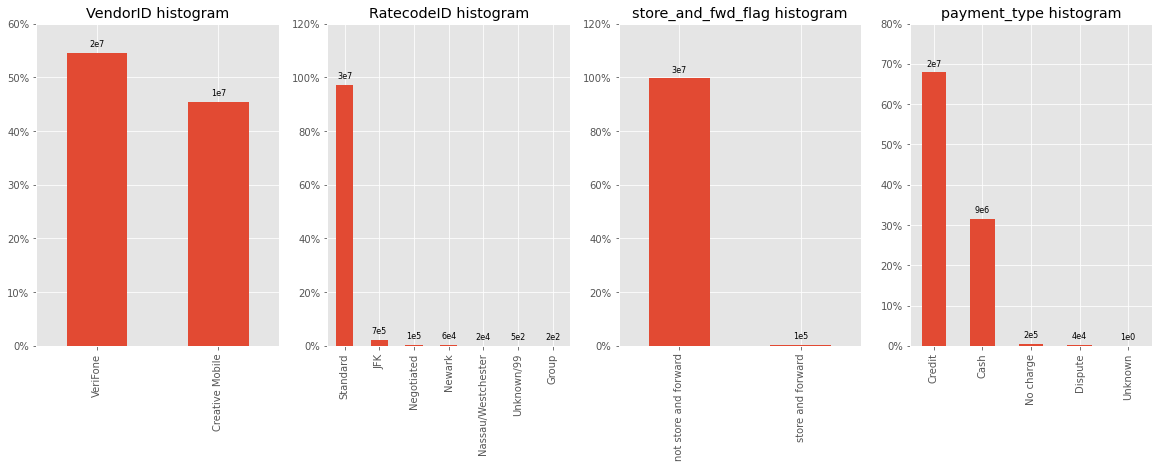

In [11]:
categorical_counts = {}
with ProgressBar():
    for cat in categorical_cols:
        cat_counts = df[cat].value_counts().compute()
        categorical_counts.update({cat: cat_counts})
plot_categorical_hists(categorical_counts)

We observe that:
    
* The annotations above each bar indicate the (approximate) number of instances within each class
* `VendorID` is almost evenly distributed
* `RatecodeID` has an unknown tag, 99, not displayed in the dictionary. It will be removed
* `store_and_fwd_flag` was not widely used by the time the data was recorded. In later stages we will analyze the impact of this variable on the target `tip_amount`.
* `payment_type` concentrates around credit and cash payments. As only credit card tips are recorded, further analysis on cash payments and its relationship with `tip_amount` will be carried out. **Disputes, non charged trips and unknown payment methods will not be considered as they should be dealt separately from regular trips**.

### Numerical variables

Seven-number summaries and the inter-percentile range are included to better asses the presence of outliers or indicate if the marginal (univariate) distributions are heavy tailed. 2 and 98 percentiles were used to this end and to define the inter-percentile range.

In [12]:
low_percentiles = [.02, 0.9]
high_percentiles = [.91, .98]
percentiles = low_percentiles + [.25, .5, .75]  + high_percentiles
percentile_idx = [f'{p:.0%}' for p in percentiles]
percentile_idx = dict(zip(percentiles, percentile_idx))

low_pct_idx = percentile_idx[percentiles[0]]
high_pct_idx = percentile_idx[percentiles[-1]]

num_descr = df[numerical_cols].describe(percentiles = percentiles)
with ProgressBar():
    num_descr = num_descr.compute()
gc.collect();

num_descr = num_descr.T
num_descr_ipr = num_descr[high_pct_idx] - num_descr[low_pct_idx]
num_descr.insert(loc=len(num_descr.columns),
                 column='ipr',
                 value=num_descr_ipr)

num_descr

[########################################] | 100% Completed |  7.7s


,count,mean,std,min,2%,25%,50%,75%,90%,91%,98%,max,ipr
passenger_count,29236424.0,1.617798,1.260992,0.000000,1.000000,1.000000,1.000000,2.000000,4.000000,5.000000,6.000000,192.000000,5.000000
trip_duration,29236424.0,16.919676,151.297516,-4280.283203,2.133333,8.266666,14.716666,23.900000,31.450001,39.283333,71.033333,757771.750000,68.899999
trip_distance,29236424.0,2.919386,4.476535,0.000000,0.350000,1.060000,1.810000,3.470000,7.690000,8.840000,18.110001,9496.980469,17.760001
fare_amount,29236424.0,13.109297,147.281662,-550.000000,4.000000,7.000000,11.000000,18.500000,27.500000,33.000000,52.000000,630461.812500,48.000000
extra,29236424.0,0.333941,0.461574,-53.709999,0.000000,0.000000,0.500000,0.500000,1.000000,1.000000,1.000000,69.800003,1.000000
mta_tax,29236424.0,0.497310,0.070817,-0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,140.000000,0.000000
tip_amount,29236424.0,1.874055,2.645570,-112.000000,0.000000,0.000000,1.550000,2.960000,4.650000,5.460000,11.650000,450.000000,11.650000
tolls_amount,29236424.0,0.329011,1.968881,-17.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.760000,1018.950012,5.760000
improvement_surcharge,29236424.0,0.299628,0.014089,-0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,1.000000,0.000000
total_amount,29236424.0,16.447101,147.524780,-550.299988,5.300000,9.360000,14.100000,22.299999,34.270000,40.560001,69.989998,630463.125000,64.689998


There are clear outliers in the data. Some of these are clearly errors:

* 192 passengers
* zero and ~9,500 (almost 3 times the coast to coast distance in the US) mile trips
* -550 and a more than a half a million dollar trip.
* negative and \$70  extras
* MTA tax out of range (should be 0.5 cent)
* negative tips, which could be due to disputes
* negative and extremely large tolls
* improvement surcharges out of range (should be 0.3 cent)

Negative amounts have been recorded in the database likely to display a refund due to a variety of reasons like disputes, cancellations, incorrect charges, etc. **These situations should be dealt independently and will be removed for subsequent analysis**.

There are columns that seem to concentrate on either few values or on alimited range, such as `passenger_count`, `extra` and  `tolls_amount` with outliers likely characterized by errors or very extreme and unlikely situations.

`mta_tax` and `improvement_surcharge` have very little  variation, IPR = 0, with a couple of deviations from the specified values of 0.5 and 0.3 mostly due to errors. **Values outside this range will be removed**.

However, variables like `trip_duration`, `trip_distance`, `fare_amount` and `tip_amount` seem to slowly grow to **have probabilistically non-negligible large fluctuations at the tails at high values**. Considering this, filtering at large values shoud be done carefully with further analysis.

The variable `total_amount` **will not be analyzed as it is the sum of surcharges, including the target `tip_amount`**.

**We will proceed as follows:**

 1. Filter out with unknown tags of categorical variables, disputes or non-charged trips, axes and surcharges outside of range and negative or zero distances, durations and fare amounts as well. 
 1. Analyze variables concentrated on a limited range to identify outliers due to errors on these variables.
 1. Further analyze the right tails of the variables suspected of having heavy tails to determine an strategy for discarding errors and dealing with these tails/outliers.

#### Passenger count

Since `passenger_count` exhibits a more concentrated distribution (indeed, the range is discrete with likely only a few errors) a simple count analysis will be performed on it. 

[########################################] | 100% Completed |  3.1s


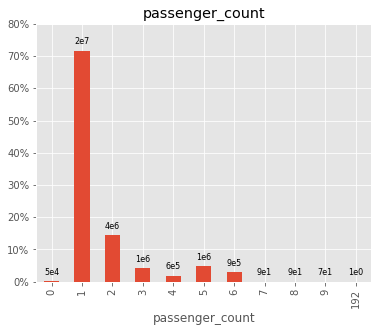

In [13]:
passenger_count_hist = df.groupby('passenger_count').size()
with ProgressBar():
    passenger_count_hist = passenger_count_hist.compute()
    counts_sum = passenger_count_hist.sum()
    passenger_count_hist /= counts_sum

counts_bar = passenger_count_hist.sort_index().plot(kind='bar');
plt.title('passenger_count');
counts_bar.set_yticks(counts_bar.get_yticks().tolist());
counts_bar.set_yticklabels([f'{y:,.0%}' for y in counts_bar.get_yticks()]);

annotate_bars(counts_bar, counts_sum)

plt.subplots_adjust(top=1.02)

Observations:

* No passengers could be either errors or courier services.
* The 192 passengers trip is the only clear error.

**Both cases will be removed for analysis since are clearly atypical ~ 50,000 total cases.**

### Data filtering

After filtering the variables, columns that have no variation, such as `mta_tax`, `improvement_surcharge` will be removed.

`total_amount` will also be removed since it contains spurious information (though, we have not verified that indeed this is the sum of all surcharges).

In [14]:
filter_ratecode = df['RatecodeID'].isin(range(1,7))
filter_payment_type = df['payment_type'].isin([1,2])

filter_positive = (df[numerical_cols] >= 0).all(axis=1)
filter_zero = (df[['trip_duration', 'trip_distance', 'fare_amount']] > 0).all(axis=1)
filter_passenger_count = df['passenger_count'].isin(range(1,10))
filter_mta = df['mta_tax'] == 0.5
filter_impr_surch = df['improvement_surcharge'] == 0.3

filter_df = (filter_ratecode & filter_payment_type &
             filter_positive & filter_zero & filter_passenger_count &
             filter_mta & filter_impr_surch)

df = df.loc[filter_df]
df = df.reset_index(drop=True)
df = df.drop(labels=['mta_tax', 'improvement_surcharge', 'total_amount'], axis=1)

First we analyze how many rows we have filtered out.

In [15]:
df_initial_n_rows = df_n_rows
df_n_rows = df.shape[0]
df_n_cols = df.shape[1]

with ProgressBar():
    df_n_rows = df_n_rows.compute()

kept_rows_ratio = df_n_rows/df_initial_n_rows

print(f'Data shape: {df_n_rows:,} rows and {df_n_cols} columns')
print(f'\tKeeping {kept_rows_ratio:.2%} of the data after filtering')
gc.collect();

[########################################] | 100% Completed |  5.2s
Data shape: 28,734,186 rows and 15 columns
	Keeping 98.28% of the data after filtering


#### Categorical variables

[########################################] | 100% Completed |  5.3s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.0s


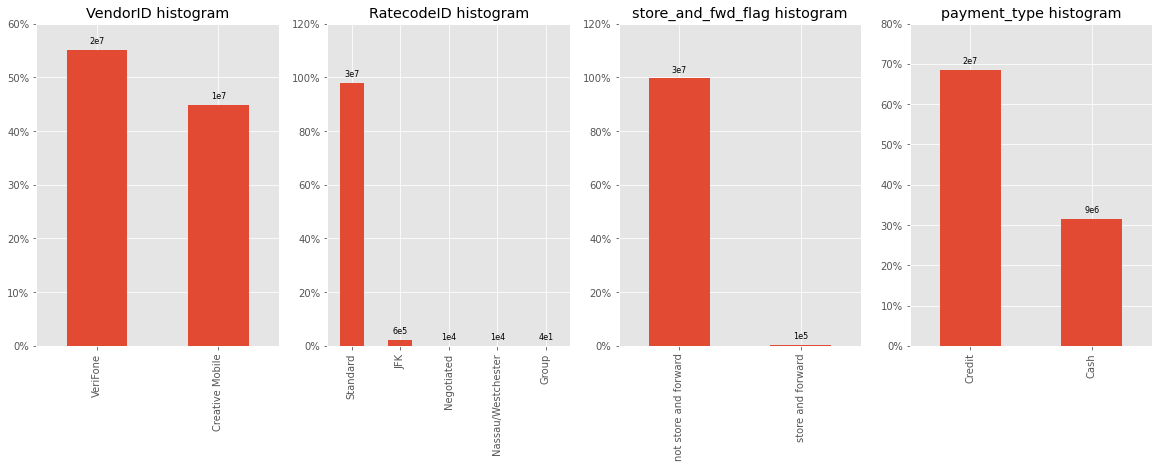

In [16]:
categorical_counts = {}
with ProgressBar():
    for cat in categorical_cols:
        cat_counts = df[cat].value_counts().compute()
        categorical_counts.update({cat: cat_counts})
plot_categorical_hists(categorical_counts)

Quite surprisingly, all non-standard rates were significantly reduced: JFK by tens of thousands, the rest by almost an order of magintude even to fully being filter out, as with the Newark fare.

**An exploratory analysis of deleted instances will be provided below.**

#### Numerical variables

Let us repeat the seven-number description of the numerical variables

In [17]:
numerical_cols = ['passenger_count', 'trip_duration',
                  'trip_distance', 'fare_amount',
                  'extra', 'tip_amount', 'tolls_amount']

num_descr = df[numerical_cols].describe(percentiles = percentiles)
with ProgressBar():
    num_descr = num_descr.compute()
gc.collect();

num_descr = num_descr.T
num_descr_ipr = num_descr[high_pct_idx] - num_descr[low_pct_idx]
num_descr.insert(loc=len(num_descr.columns),
                 column='ipr',
                 value=num_descr_ipr)

num_descr

[########################################] | 100% Completed |  8.4s


,count,mean,std,min,2%,25%,50%,75%,90%,91%,98%,max,ipr
passenger_count,28734186.0,1.624408,1.263884,1.000000,1.000000,1.00,1.000,2.000000,4.000000,5.000000,6.00000,9.000000,5.000000
trip_duration,28734186.0,16.954713,152.469238,0.016667,2.566667,8.40,14.800,23.766666,31.366667,39.133335,70.73333,757771.750000,68.166663
trip_distance,28734186.0,2.896147,3.641891,0.010000,0.400000,1.07,1.815,3.470000,7.570000,8.700000,17.98000,770.000000,17.580000
fare_amount,28734186.0,12.849905,118.077049,0.010000,4.000000,7.50,11.000,18.500000,27.000000,32.000000,52.00000,630461.812500,48.000000
extra,28734186.0,0.335095,0.455693,0.000000,0.000000,0.00,0.500,0.500000,1.000000,1.000000,1.00000,65.300003,1.000000
tip_amount,28734186.0,1.852695,2.475560,0.000000,0.000000,0.00,1.560,2.960000,4.560000,5.450000,11.27000,450.000000,11.270000
tolls_amount,28734186.0,0.292016,1.480099,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,5.76000,975.599976,5.760000


Observe that most quantities, except of course the minima, remain largely unchanged or close to the previous values. This is another indication that some variables have indeed heavy tails.
A notable exception is the maximum of `trip_distance` which has been filtered out as an anomalous instance.

### Outlier analysis (univariate)

#### Narrow tailed variables

`extra` and `tolls_amount` seem to be very concentrated around their median, yet appear to be skewed respectively to the right and to the left.

In [51]:
def get_bxpstats(var,
                 num_descr,
                 low_pct_idx=low_pct_idx,
                 high_pct_idx=high_pct_idx,
                 ipr_scale=3,
                 clip_low=False,
                 clip_high=False):
    
    var_min = num_descr.loc[var, 'min']
    var_max = num_descr.loc[var, 'max']
    var_median = num_descr.loc[var, '50%']
    var_low_pct_score = num_descr.loc[var, low_pct_idx]
    var_high_pct_score = num_descr.loc[var, high_pct_idx]
    var_ipr = num_descr.loc[var, 'ipr']

    var_low_whisker = var_low_pct_score - ipr_scale*var_ipr
    var_high_whisker = var_high_pct_score + ipr_scale*var_ipr

    if clip_low:
        var_low_whisker = max(var_low_whisker, var_min)
    if clip_high:
        var_low_whisker = min(var_low_whisker, var_max)
    
    bxpstats = {'label': '',
                'whislo': var_low_whisker,
                'q1': var_low_pct_score,
                'med': var_median,
                'q3': var_high_pct_score,
                'whishi': var_high_whisker,
                'fliers': [var_min, var_max]}
    
    return bxpstats

def ipr_hist(var,
             num_descr,
             nbins=100,
             right_tail=False,
             clip_low=False,
             clip_high=False):
    
    bxpstats = get_bxpstats(var,
                            num_descr,
                            clip_low=clip_low,
                            clip_high=clip_high)
    
    range_low = bxpstats['whislo']
    range_high = bxpstats['whishi']
    var_min, var_max = bxpstats['fliers']
    
    var_counts, var_bins = da.histogram(df[var],
                                        bins=nbins,
                                        range=[range_low,
                                               range_high])
    var_bin_center = (var_bins[:-1] + var_bins[1:])/2
    var_bin_width = 0.7*(var_bins[1] - var_bins[0])
    
    var_ipr_hist = var_counts, var_bin_center, var_bin_width
    
    def right_tail_log_hist(var, nbins=100):
        var_rt_counts, var_rt_bins = da.histogram(df[var],
                                                  bins=nbins,
                                                  range=[range_high,
                                                         var_max])

        var_rt_bin_center = var_rt_bins[:-1]
        var_rt_bin_width = (10**(np.log10(var_rt_bin_center) + 0.5/2) -
                            10**(np.log10(var_rt_bin_center) - 0.5/2))

        var_rt_log_hist = var_rt_counts, var_rt_bin_center, var_rt_bin_width
        return var_rt_log_hist
    
    if right_tail:
        var_rt_log_hist = right_tail_log_hist(var)
        
        return var_ipr_hist, var_rt_log_hist
    else:
        return var_ipr_hist

def plot_hist(bin_center,
              counts,
              bin_width,
              ylog=False,
              xlog=False,
              ax=None,
              **kwargs):

    if ax is None:
        ax = plt.gca()

    counts_bar = ax.bar(x=bin_center,
                        height=counts,
                        width=bin_width,
                        align='center');
    ax.set_ylabel('Counts');
    
    if xlog:
        ax.set_xscale('log');
    
    if ylog:
        ax.set_yscale('log');
    
    return ax


def plot_narrow_hists(narrow_hists,
                      num_descr=num_descr,
                      clip_low=True):
    ncols = 2
    nrows = len(narrow_hists)
    scale = 5
    figsize = (ncols * scale, nrows * scale)
    f, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    plt.suptitle('Narrow-tailed distributions', size=17);
    for idx, (var, hist) in enumerate(narrow_hists.items()):
        
        bxpstats = get_bxpstats(var,
                        num_descr,
                        clip_low=clip_low)
        bxpstats = [bxpstats]
        
        counts, bin_center, bin_width = hist
        counts_sum = counts.sum()
        counts_norm = counts/counts_sum
        counts_bar = plot_hist(bin_center,
                               counts_norm,
                               bin_width,
                               ax=ax[idx, 0])

        ax[idx, 0].set_title(f'{var} within IPR histogram')
        ax[idx, 0].set_yticks(ax[idx, 0].get_yticks().tolist());
        ax[idx, 0].set_yticklabels([f'{y:,.0%}' for y in ax[idx, 0].get_yticks()]);
        
        annotate_bars(counts_bar, counts_sum)
        
        ax[idx, 1].bxp(bxpstats, showfliers=True, vert=False);
        ax[idx, 1].set_title(f'{var} IPR boxplot with max and min')
        ax[idx, 1].set_xscale('log');
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]);

In [30]:
narrow_hists = {}
for var in ['extra', 'tolls_amount']:
    with ProgressBar():
        var_ipr_hist = ipr_hist(var, num_descr, nbins=10, right_tail=False, clip_low=True)
        var_counts, var_bin_center, var_bin_width = var_ipr_hist
        var_counts = var_counts.compute()
        narrow_hists.update({var: (var_counts, var_bin_center, var_bin_width)})
plot_narrow_hists(narrow_hists)

[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.6s


#### Heavy tailed variables

`Dask` forces the user to define a range prior the execution of it's base histogram function.

This and the large size of the support of `trip_duration`, `trip_distance`, `fare_amount` and `tip_amount` makes us to

1. first examine the inter-quantile (2%-98%) histograms
1. then analyze a separate histogram for the right/high tail
1. lastly produce a boxplot over the whole (positive range) including the maxima and minima.

In [18]:
def plot_heavy_right_hists(heavy_tailed_hists,
                           num_descr=num_descr,
                           clip_low=True):
    ncols = 3
    nrows = len(heavy_tailed_hists)
    scale = 5
    figsize = (ncols * scale, nrows * scale)
    f, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    plt.suptitle('Heavy-tailed distributions', size=17);
    for idx, var in enumerate(heavy_tailed_hists.keys()):
            counts, bin_center, bin_width = heavy_tailed_hists[var]['var_ipr_hist']
            rt_counts, rt_bin_center, rt_bin_width = heavy_tailed_hists[var]['var_rt_log_hist']

            bxpstats = get_bxpstats(var,
                                    num_descr,
                                    clip_low=clip_low)
            bxpstats = [bxpstats]

            plot_hist(bin_center,
                      counts,
                      bin_width,
                      ylog=True,
                      ax=ax[idx, 0])
            ax[idx, 0].set_title(f'{var} within IPR log counts histogram');


            plot_hist(rt_bin_center,
                      rt_counts,
                      rt_bin_width,
                      xlog=True,
                      ylog=True,
                      ax=ax[idx, 1])    
            ax[idx, 1].set_title(f'{var} right tail log-log historgam');
            ax[idx, 1].set_xlabel(f'{var}');

            ax[idx, 2].bxp(bxpstats, showfliers=True, vert=False);
            ax[idx, 2].set_title(f'{var} IPR boxplot with max and min')
            ax[idx, 2].set_xscale('log');

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]);

[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.5s


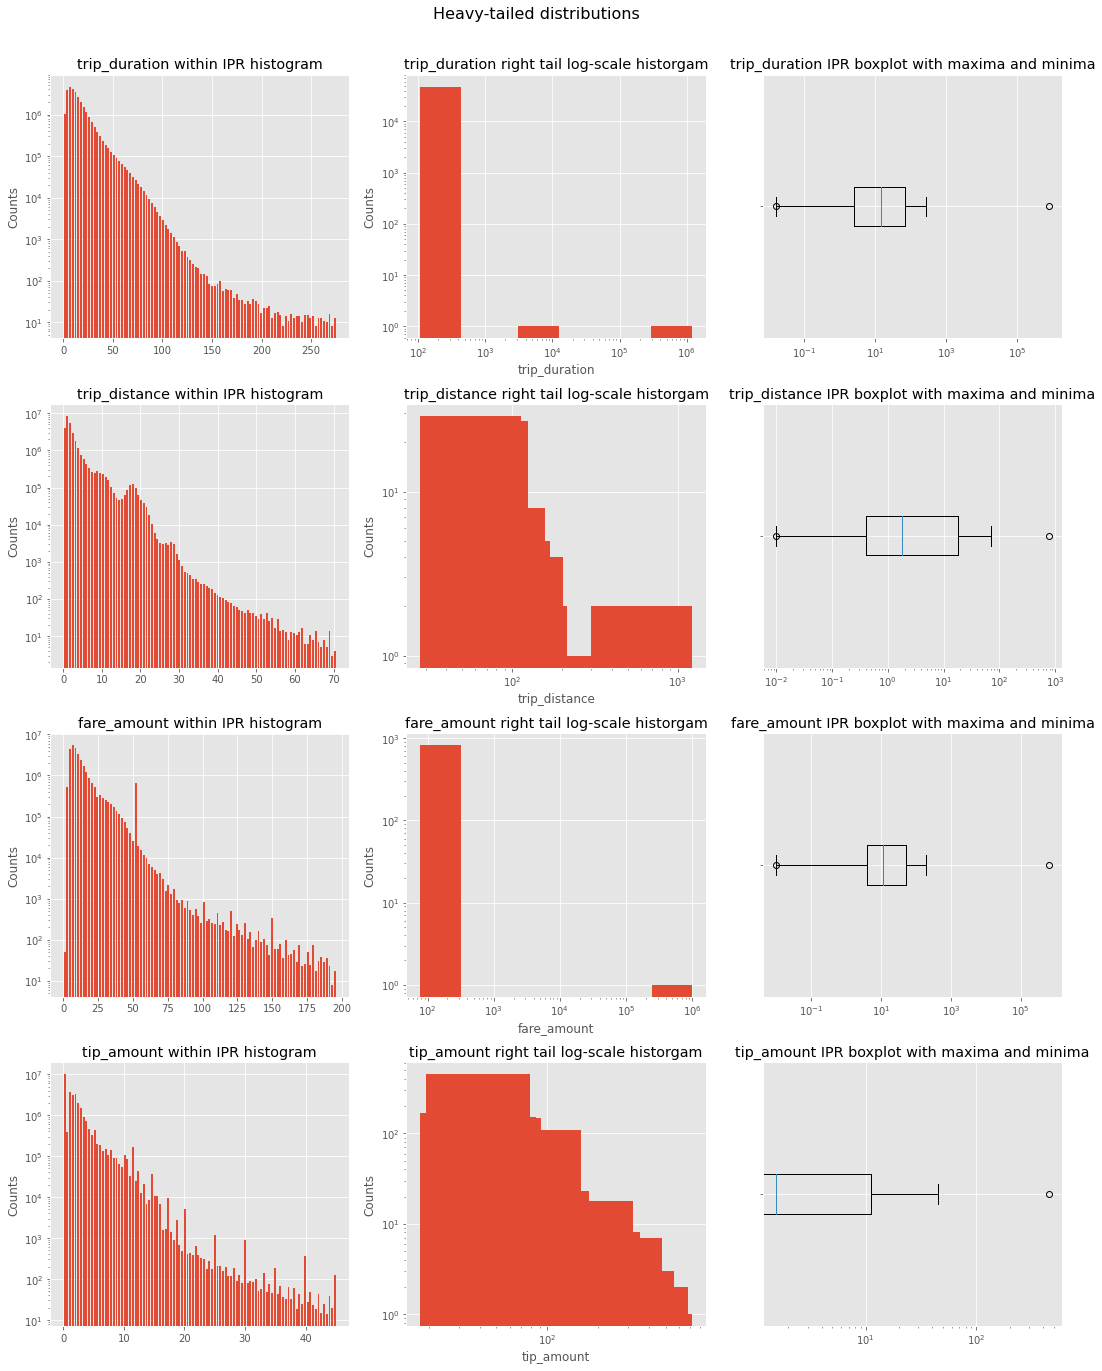

In [20]:
heavy_tailed_cols = ['trip_duration', 'trip_distance',
                     'fare_amount', 'tip_amount']

heavy_tailed_hists = {}
for var in heavy_tailed_cols:
    var_ipr_hist, var_rt_log_hist = ipr_hist(var, num_descr, right_tail=True, clip_low=True)
    var_counts, var_bin_center, var_bin_width = var_ipr_hist
    var_rt_counts, var_rt_bin_center, var_rt_bin_width = var_rt_log_hist
    with ProgressBar():
        var_counts = var_counts.compute()
        var_rt_counts = var_rt_counts.compute()

    var_ipr_hist = var_counts, var_bin_center, var_bin_width
    var_rt_log_hist = var_rt_counts, var_rt_bin_center, var_rt_bin_width
    
    var_hists = {var: {'var_ipr_hist': var_ipr_hist,
                       'var_rt_log_hist': var_rt_log_hist}}
    heavy_tailed_hists.update(var_hists)
    
plot_heavy_right_hists(heavy_tailed_hists)

In [28]:
10**np.ceil(np.log10(num_descr['98%'] + 3*num_descr['ipr']))

passenger_count     100.0
trip_duration      1000.0
trip_distance       100.0
fare_amount        1000.0
extra                10.0
tip_amount          100.0
tolls_amount        100.0
dtype: float64

# TODO

1. ~~Adapt narrow plots to hist_plot~~
1. ~~Add boxplot~~
1. Coments on heavy and on thin

##  Data istances with anomalous numerical variables (filtered out)

We will explore rows with negative numerical values or zero fare amount that were discarded from the data. 

Since the count of these trips is very small relative to the whole data set, it is a good idea to drop them to decrease sources of noise.

### Negative charges

These rows have been regarded as anomalous from the start of the analysis. 
They might have been recorded in the database to display a refund due to a variety of reasons like disputes, cancellations, incorrect charges, etc.

To back up this hypothesis we will dispay the payment type distribution and a scatter plot of distance vs trip duration in minutes.

As these isntances are relatively small, we can handle the analysis in memory.

In [27]:
with ProgressBar():
    df_neg = df_neg.compute()
    df_zero_fare = df_zero_fare.compute()
gc.collect();

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.9s


* The payment type histogram shows that indeed most of these records are refunds, some of them due to disputes. 

* As plotted, most of these cases correspond to extremely short trips in time, in distance or both.

* Note that longest of these trips cluster at day-long trips (1,400 minutes).

* Around 20-30 of these trips may be actual trips with a correction on a given surcharge.

* No further validation will be performed due to time constraints (for exaple, looking for explantory variables). 

* About a third of these instances do correspond to non-charged trips or trips with disputes.

* The remaining cases could correspond to free trips or errors while recording them.

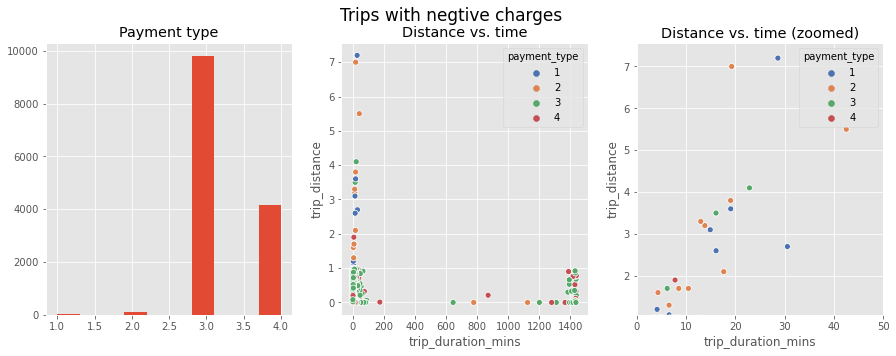

In [29]:
ncols = 3
nrows = 1
scale = 5
figsize = (ncols * scale, nrows * scale)
_, ax = plt.subplots(nrows, ncols, figsize=figsize)

plt.suptitle('Trips with negtive charges', size=17);

df_neg.payment_type.hist(ax=ax[0]);
ax[0].set_title('Payment type');

sns.scatterplot(data=df_neg,
                x='trip_duration_mins',
                y='trip_distance',
                hue=df_neg.payment_type.tolist(),
                legend='full',
                palette='deep',
                ax=ax[1]);
ax[1].legend(loc='best', 
             title='payment_type')

ax[1].set_title('Distance vs. time');

sns.scatterplot(data=df_neg,
                x='trip_duration_mins',
                y='trip_distance',
                hue=df_neg.payment_type.tolist(),
                palette='deep',
                ax = ax[2]);
ax[2].legend(loc='best', 
             title='payment_type')
ax[2].set_ylim(1.07)
ax[2].set_xlim(0, 50)
ax[2].set_title('Distance vs. time (zoomed)');

In [65]:
num_descr_high_whisker = num_descr[high_pct_idx] + 3*num_descr['ipr'] 
num_descr_high_whisker = num_descr_high_whisker.drop(labels='passenger_count', axis=0)
num_descr_high_whisker = num_descr_high_whisker.to_dict()

high_outliers = []
for col in num_descr_high_whisker.keys():
    col_filter = df[col] > num_descr_high_whisker[col]
    col_filter.name = f'{col}_riotlr_filt'
    high_outliers.append(col_filter)

high_outliers = dd.concat(high_outliers,
                          axis=1,
                          ignore_unknown_divisions=True).any(axis=1)

df_outliers = df[high_outliers]

outliers_num_descr = df_outliers[numerical_cols].describe()
with ProgressBar():
    outliers_num_descr = outliers_num_descr.compute()
gc.collect();

outliers_num_descr = outliers_num_descr.T

outliers_num_descr